In [4]:
import torch
import torch.nn as nn
import numpy as np
from torchvision.transforms import ToTensor
import cv2


class LaplacianBlurDetector(nn.Module):
    def __init__(self):
        super(LaplacianBlurDetector, self).__init__()
        # Define the Laplacian kernel as a parameter
        self.kernel = nn.Parameter(
            torch.tensor([[[[0, 1, 0], [1, -4, 1], [0, 1, 0]]]], dtype=torch.float32),
            requires_grad=False,
        ).cuda()  # Send the kernel to the GPU

    def forward(self, image):
        
        # Apply the Laplacian kernel to the image
        laplace = nn.functional.conv2d(image, self.kernel, padding=1)
        variance = torch.var(laplace)
        return variance


def load_image_as_tensor(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError("Image not found")
    image = image.astype(np.float32) / 255.0
    tensor = ToTensor()(image)  # Adds a channel dimension
    tensor = tensor.unsqueeze(0)  # Adds a batch dimension
    tensor = tensor.cuda()  # Send tensor to GPU
    return tensor


def is_blurry(image_path, threshold=15):
    detector = LaplacianBlurDetector().eval()  # Instance already on GPU
    image_tensor = load_image_as_tensor(image_path)
    with torch.no_grad():  # Disable gradient computation
        blur_score = detector(image_tensor).item()
    return blur_score < threshold, blur_score

detector = LaplacianBlurDetector().eval()
if torch.cuda.is_available():
    detector = detector.cuda()

In [5]:
def fetch_and_check_blurry(image_path):
    image_tensor = load_image_as_tensor(image_path)
    with torch.no_grad():
        blur_score = detector(image_tensor.cuda())
        is_blurry = blur_score.item() #< 0.0009349129324103733
        b_score = blur_score.item()

    if is_blurry:
        return image_path, b_score
    return None


In [6]:
import os

folder_path = r".\2021 Final Root Images\2021 Final Root Images\2021 Energy Farm Sorghum Root Imaging\Data"

total_files = [
    os.path.join(folder_path, f)
    for f in os.listdir(folder_path)
    if f.lower().endswith((".png", ".jpg", ".jpeg"))
]

In [7]:
from tqdm import tqdm

In [16]:
image_list = []
bval = []
for _,file in tqdm(enumerate(total_files)):
    var = fetch_and_check_blurry(file)
    try: 
        fname = var[0]
        blurval = var[1]
        image_list.append(fname)
        bval.append(blurval)
    except:
        pass

19340it [01:42, 188.28it/s]


In [17]:
print(len(image_list))

19340


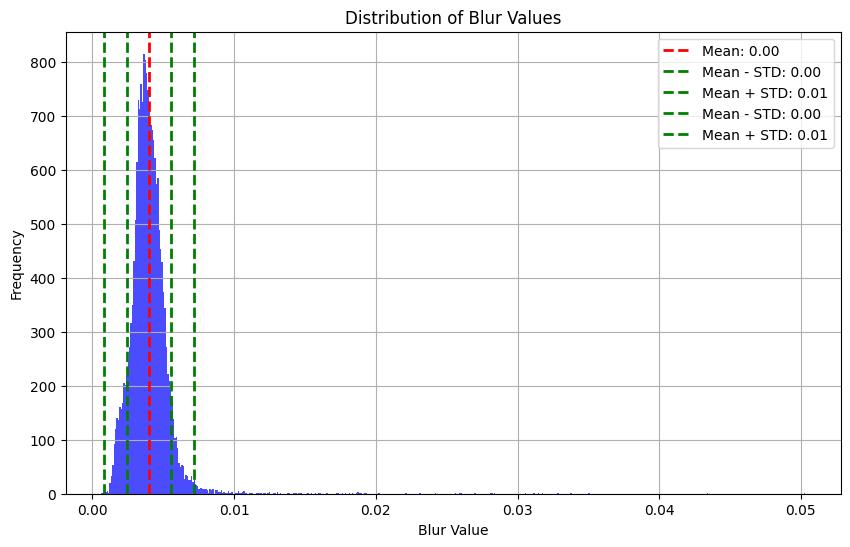

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `bval` contains all the blur values you've gathered
mean_val = np.mean(bval)
std_val = np.std(bval)

plt.figure(figsize=(10, 6))
plt.hist(bval, bins=500, color='blue', alpha=0.7)
plt.title('Distribution of Blur Values')
plt.xlabel('Blur Value')
plt.ylabel('Frequency')
plt.grid(True)

# Add vertical lines for the mean and std deviation
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(mean_val - std_val, color='green', linestyle='dashed', linewidth=2, label=f'Mean - STD: {mean_val - std_val:.2f}')
plt.axvline(mean_val + std_val, color='green', linestyle='dashed', linewidth=2, label=f'Mean + STD: {mean_val + std_val:.2f}')
plt.axvline(mean_val - 2*std_val, color='green', linestyle='dashed', linewidth=2, label=f'Mean - STD: {mean_val - std_val:.2f}')
plt.axvline(mean_val + 2*std_val, color='green', linestyle='dashed', linewidth=2, label=f'Mean + STD: {mean_val + std_val:.2f}')


# Add a legend to the plot
plt.legend()

plt.show()

In [27]:
import torch
import torch.nn as nn
import numpy as np
from torchvision.transforms import ToTensor, Resize
import cv2


class LaplacianBlurDetector(nn.Module):
    def __init__(self):
        super(LaplacianBlurDetector, self).__init__()
        # Define the Laplacian kernel as a parameter
        self.kernel = nn.Parameter(
            torch.tensor([[[[0, 1, 0], [1, -4, 1], [0, 1, 0]]]], dtype=torch.float32),
            requires_grad=False,
        ).cuda()  # Send the kernel to the GPU

    # def forward(self, image):
    #     # Apply the Laplacian kernel to the image
    #     laplace = nn.functional.conv2d(image, self.kernel, padding=1)
    #     variance = torch.var(laplace)
    #     return variance

    def forward(self, image, scales=[1.0], use_edge_detection=False):
        # Apply histogram equalization
        image = self.histogram_equalization(image)

        # Compute the Laplacian across multiple scales
        variances = []
        for scale in scales:
            scaled_image = self.scale_image(image, scale)
            if use_edge_detection:
                scaled_image = self.apply_edge_detection(scaled_image)
            laplace = nn.functional.conv2d(
                scaled_image, self.kernel, padding=self.kernel.size(2) // 2
            )
            variance = torch.var(laplace)
            variances.append(variance)

        # Return the maximum variance across scales
        variances_tensor = torch.stack(variances)
        return torch.mean(variances_tensor)

    def histogram_equalization(self, image):
        # Assume the image is a batch of single-channel grayscale images
        batch_size, channels, height, width = image.shape
        for i in range(batch_size):
            img = image[i].cpu().numpy().squeeze()  # Remove channel dimension for CV2
            img_eq = cv2.equalizeHist(img.astype(np.uint8))
            # Correctly reshape the numpy array to maintain the original dimensions
            img_eq = img_eq.reshape((1, height, width))  # Include channel dimension
            image[i] = torch.from_numpy(img_eq).to(image.device).float() / 255.0
        return image

    def scale_image(self, image, scale):
        if scale == 1.0:
            return image
        else:
            _, _, H, W = image.shape
            new_H, new_W = int(H * scale), int(W * scale)
            resize = Resize((new_H, new_W))
            return resize(image)

    def apply_edge_detection(self, image):
        edge_kernel = torch.tensor(
            [[[[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]]], dtype=torch.float32
        ).cuda()
        edges = nn.functional.conv2d(image, edge_kernel, padding=1)
        return edges

In [3]:
def load_image_as_tensor(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError("Image not found")
    image = image.astype(np.float32) / 255.0
    tensor = ToTensor()(image)  # Adds a channel dimension
    tensor = tensor.unsqueeze(0)  # Adds a batch dimension
    tensor = tensor.cuda()  # Send tensor to GPU
    return tensor


def is_blurry(image_path, threshold=15):
    detector = LaplacianBlurDetector().eval()  # Instance already on GPU
    image_tensor = load_image_as_tensor(image_path)
    with torch.no_grad():  # Disable gradient computation
        blur_score = detector(image_tensor).item()
    return blur_score < threshold, blur_score

detector = LaplacianBlurDetector().eval()
if torch.cuda.is_available():
    detector = detector.cuda()

NameError: name 'LaplacianBlurDetector' is not defined

In [31]:
def fetch_and_check_blurry(image_path):
    image_tensor = load_image_as_tensor(image_path)
    with torch.no_grad():
        blur_score = detector(
                image_tensor, scales=[1.0, 0.5, 0.25], use_edge_detection=True
            )
        is_blurry = blur_score.item() #< 0.0009349129324103733
        b_score = blur_score.item()

    if is_blurry:
        return image_path, b_score
    return None

In [32]:
image_list = []
bval = []
for _,file in tqdm(enumerate(total_files)):
    var = fetch_and_check_blurry(file)
    try: 
        fname = var[0]
        blurval = var[1]
        image_list.append(fname)
        bval.append(blurval)
    except:
        pass

19340it [02:42, 119.26it/s]


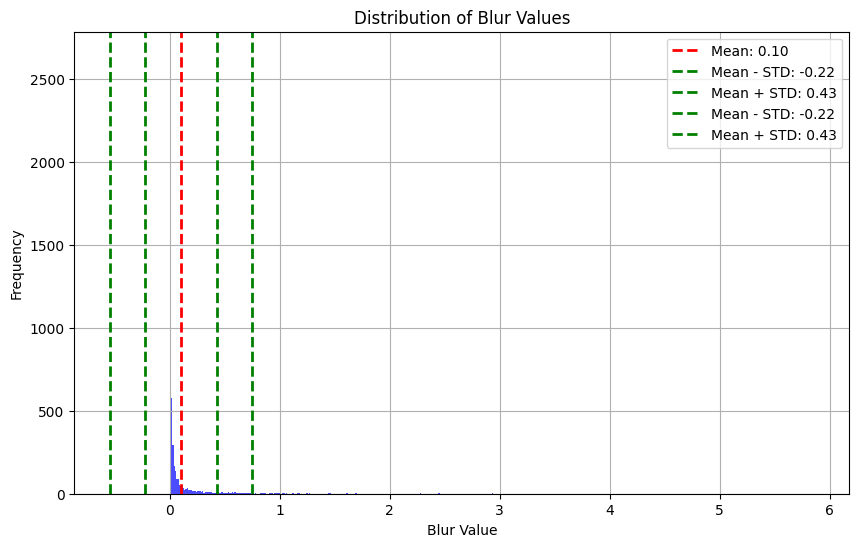

In [33]:
# Assuming `bval` contains all the blur values you've gathered
mean_val = np.mean(bval)
std_val = np.std(bval)

plt.figure(figsize=(10, 6))
plt.hist(bval, bins=500, color='blue', alpha=0.7)
plt.title('Distribution of Blur Values')
plt.xlabel('Blur Value')
plt.ylabel('Frequency')
plt.grid(True)

# Add vertical lines for the mean and std deviation
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(mean_val - std_val, color='green', linestyle='dashed', linewidth=2, label=f'Mean - STD: {mean_val - std_val:.2f}')
plt.axvline(mean_val + std_val, color='green', linestyle='dashed', linewidth=2, label=f'Mean + STD: {mean_val + std_val:.2f}')
plt.axvline(mean_val - 2*std_val, color='green', linestyle='dashed', linewidth=2, label=f'Mean - STD: {mean_val - std_val:.2f}')
plt.axvline(mean_val + 2*std_val, color='green', linestyle='dashed', linewidth=2, label=f'Mean + STD: {mean_val + std_val:.2f}')


# Add a legend to the plot
plt.legend()

plt.show()

In [8]:
class LaplacianBlurDetector(nn.Module):
    def __init__(self):
        super(LaplacianBlurDetector, self).__init__()
        # Define the Laplacian kernel as a parameter
        self.kernel = nn.Parameter(
            torch.tensor([[[[0, 1, 0], [1, -4, 1], [0, 1, 0]]]], dtype=torch.float32),
            requires_grad=False,
        ).cuda()  # Send the kernel to the GPU

    def forward(self, image):
        # Apply the Laplacian kernel to the image
        image = self.histogram_equalization(image)
        laplace = nn.functional.conv2d(image, self.kernel, padding=1)
        variance = torch.var(laplace)
        return variance

    def histogram_equalization(self, image):
        # Assume the image is a batch of single-channel grayscale images
        batch_size, channels, height, width = image.shape
        for i in range(batch_size):
            img = image[i].cpu().numpy().squeeze()  # Remove channel dimension for CV2
            img_eq = cv2.equalizeHist(img.astype(np.uint8))
            # Correctly reshape the numpy array to maintain the original dimensions
            img_eq = img_eq.reshape((1, height, width))  # Include channel dimension
            image[i] = torch.from_numpy(img_eq).to(image.device).float() / 255.0
        return image

In [9]:
def load_image_as_tensor(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError("Image not found")
    image = image.astype(np.float32) / 255.0
    tensor = ToTensor()(image)  # Adds a channel dimension
    tensor = tensor.unsqueeze(0)  # Adds a batch dimension
    tensor = tensor.cuda()  # Send tensor to GPU
    return tensor


def is_blurry(image_path, threshold=15):
    detector = LaplacianBlurDetector().eval()  # Instance already on GPU
    image_tensor = load_image_as_tensor(image_path)
    with torch.no_grad():  # Disable gradient computation
        blur_score = detector(image_tensor).item()
    return blur_score < threshold, blur_score

detector = LaplacianBlurDetector().eval()
if torch.cuda.is_available():
    detector = detector.cuda()

In [10]:
image_list = []
bval = []
for _,file in tqdm(enumerate(total_files)):
    var = fetch_and_check_blurry(file)
    try: 
        fname = var[0]
        blurval = var[1]
        image_list.append(fname)
        bval.append(blurval)
    except:
        pass

19340it [02:36, 123.83it/s]


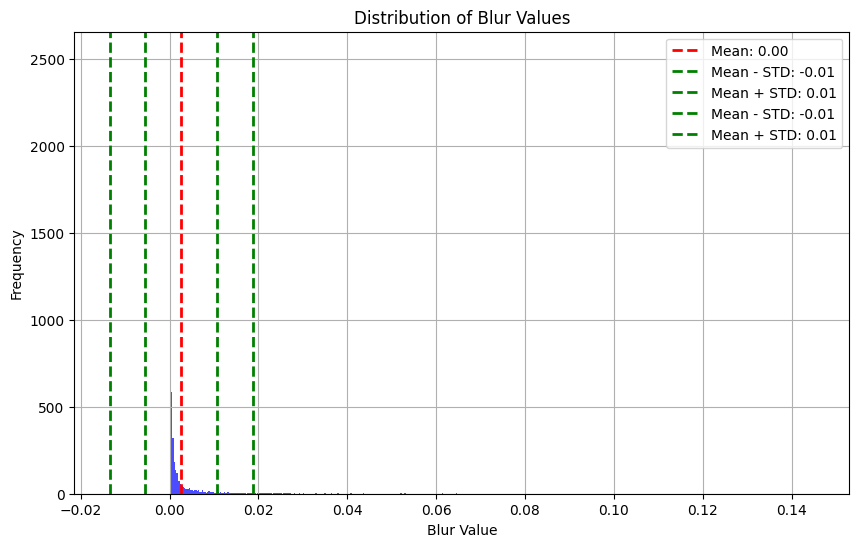

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `bval` contains all the blur values you've gathered
mean_val = np.mean(bval)
std_val = np.std(bval)

plt.figure(figsize=(10, 6))
plt.hist(bval, bins=500, color='blue', alpha=0.7)
plt.title('Distribution of Blur Values')
plt.xlabel('Blur Value')
plt.ylabel('Frequency')
plt.grid(True)

# Add vertical lines for the mean and std deviation
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(mean_val - std_val, color='green', linestyle='dashed', linewidth=2, label=f'Mean - STD: {mean_val - std_val:.2f}')
plt.axvline(mean_val + std_val, color='green', linestyle='dashed', linewidth=2, label=f'Mean + STD: {mean_val + std_val:.2f}')
plt.axvline(mean_val - 2*std_val, color='green', linestyle='dashed', linewidth=2, label=f'Mean - STD: {mean_val - std_val:.2f}')
plt.axvline(mean_val + 2*std_val, color='green', linestyle='dashed', linewidth=2, label=f'Mean + STD: {mean_val + std_val:.2f}')


# Add a legend to the plot
plt.legend()

plt.show()

In [11]:
import numpy as np

ar = np.array(bval)
print(ar.mean())
print(ar.std())

0.0008149497443810105
0.00011853525211217448


In [88]:
0.005128593673964185 - 1.5 * 0.002795787161035874

0.0009349129324103733

Trials for Emptiness detection Algorithms.

In [5]:
import numpy as np
import cv2
import os
from tqdm import tqdm

def is_image_empty_edges_cuda(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError("Image not found")
    
    # Perform Canny edge detection on GPU
    edges= cv2.Canny(image, 50, 150)

    
    non_zero_count = cv2.countNonZero(edges)
    image_area = image.shape[0] * image.shape[1]

    # Define a threshold for what is considered "mostly empty"
    threshold = image_area * 0.01  # adjust as necessary
    return non_zero_count < threshold

# Paths
folder_path = r"W:\Summer Research Work\2021 Final Root Images\2021 Final Root Images\2021 Rainout Shelter Sorghum Root Imaging\Data"
empty_images_folder = os.path.join(folder_path, "empty_images")

# Create a folder for empty images if it doesn't exist
if not os.path.exists(empty_images_folder):
    os.makedirs(empty_images_folder)

# Get all image files
total_files = [
    os.path.join(folder_path, f)
    for f in os.listdir(folder_path)
    if f.lower().endswith((".png", ".jpg", ".jpeg"))
]

# Classify and move empty images
for file in tqdm(total_files):
    if is_image_empty_edges_cuda(file):
        # Move the empty image to the empty_images_folder
        new_path = os.path.join(empty_images_folder, os.path.basename(file))
        os.rename(file, new_path)

ModuleNotFoundError: No module named 'cv2'